In [1]:
from transformers import BertTokenizer
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from transformers import BertModel
from transformers import BertForSequenceClassification
from torch.optim import Adam
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as skmetrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
path_to_data = "/kaggle/input/contacts-in-text/"

In [3]:
raw_train_data = pd.read_csv(path_to_data + "train.csv")
raw_train_data

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - евро...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n ...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в ...,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0
...,...,...,...,...,...,...,...,...,...
984482,Штампы 61r,+79780979761/\nДенис/\nширину обода и вылет на...,Запчасти и аксессуары,Транспорт,2000.0,Крым,Мирное,2019-10-09 23:55:54.099019,1
984483,Juul,Зарядка и под в комплекте.,Коллекционирование,Хобби и отдых,1200.0,Россия,Москва,2019-10-09 23:56:13.283059,0
984484,Белый стул IKEA,Белый стул Ikea /\nСостояние требует ремонта: ...,Мебель и интерьер,Для дома и дачи,500.0,Россия,Санкт-Петербург,2019-10-09 23:58:42.377241,0
984485,"5-к квартира, 32 м², 2/2 эт.",Бронирование с октября по январь 1010 г./\n ...,Квартиры,Недвижимость,800.0,Калининградская область,Калининград,2019-10-09 23:59:26.744680,0


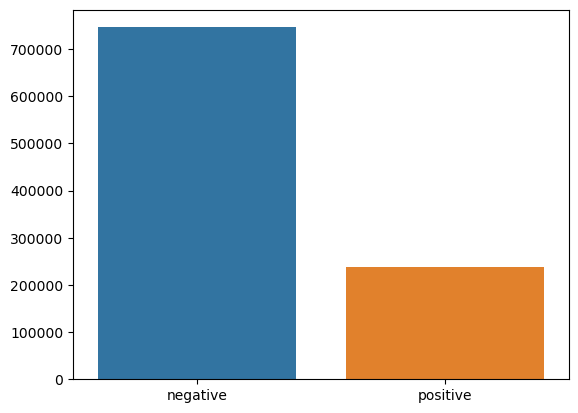

In [4]:
dd = pd.Series(raw_train_data.is_bad).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()   # Количество негативных в три раза больше позитивных

In [5]:
raw_train_data.apply(lambda x: x.factorize()[0]).corr()
# Корреляции между полями и таргетом почти нет, 
# разве что слабая корреляция таргета и города

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
title,1.000000,0.593031,-0.017894,-0.052575,0.080396,-0.065685,-0.059377,0.593029,-0.043398
description,0.593031,1.000000,-0.016607,0.026769,0.049865,0.002993,0.006403,0.999934,0.003939
subcategory,-0.017894,-0.016607,1.000000,0.521404,0.023756,0.032745,0.082077,-0.016619,0.073613
category,-0.052575,0.026769,0.521404,1.000000,0.009689,0.033172,0.041488,0.026792,0.029254
price,0.080396,0.049865,0.023756,0.009689,1.000000,-0.071317,-0.042398,0.049847,-0.039231
region,-0.065685,0.002993,0.032745,0.033172,-0.071317,1.000000,0.177140,0.003012,0.073541
city,-0.059377,0.006403,0.082077,0.041488,-0.042398,0.177140,1.000000,0.006393,0.202091
datetime_submitted,0.593029,0.999934,-0.016619,0.026792,0.049847,0.003012,0.006393,1.000000,0.003906
is_bad,-0.043398,0.003939,0.073613,0.029254,-0.039231,0.073541,0.202091,0.003906,1.000000


In [6]:
# Делю выборку на train, test
np.random.seed(1)

df_train, df_test = np.split(raw_train_data.sample(frac=1, random_state=42),
                                    [int(.95*len(raw_train_data))])

print(len(df_train), len(df_test))

935262 49225


In [7]:
df_val = pd.read_csv(path_to_data + "val.csv")

# Baseline-модель
Для сравнения модели с использованием трансформеров, создам простую baseline модель на лог. регрессии с tf-idf.

In [45]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000))
])

In [46]:
pipeline.fit(df_train["description"], df_train["is_bad"])
best_predictions = pipeline.predict(df_test["description"])

In [47]:
print(classification_report(best_predictions, df_test["is_bad"]))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     39624
           1       0.71      0.88      0.79      9601

    accuracy                           0.91     49225
   macro avg       0.84      0.90      0.86     49225
weighted avg       0.92      0.91      0.91     49225



In [48]:
test_preds_df = pd.DataFrame()

In [49]:
test_preds_df["category"] = df_test["category"]
test_preds_df["is_bad"] = df_test["is_bad"]
test_preds_df["prediction"] = best_predictions.tolist()

In [13]:
# AUC-ROC по всем предсказаниям.
roc_auc_score(test_preds_df["is_bad"], 
              test_preds_df["prediction"])

In [14]:
# Подсчет AUC-ROC по предсказаниям по категориям.
def get_avg_auc_by_categories(data, predictions):
    categories = data["category"].unique()

    auc_roc_scores = []

    for category in categories:
        auc_roc_scores.append(
            roc_auc_score(predictions[predictions["category"] == category]["is_bad"], 
                  predictions[predictions["category"] == category]["prediction"])
        )
    
    avg_auc_roc_scores = pd.Series(auc_roc_scores, index=categories).mean()
    return avg_auc_roc_scores

In [50]:
get_avg_auc_by_categories(raw_train_data, test_preds_df)

0.8110559899281613

# Классификатор

In [16]:
BERT_PRETRAINED = "cointegrated/rubert-tiny"

In [17]:
tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED)

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = df['is_bad'].to_list()
        self.texts = df['description'].to_list()
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [19]:
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained(BERT_PRETRAINED)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(312, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_id, mask):
        
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)

        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigmoid(linear_output)
        
        return final_layer.squeeze(1)

In [20]:
small_df_train = df_train.groupby('is_bad').apply(lambda x: x.sample(50000))

train, val = Dataset(small_df_train), Dataset(df_val)

In [22]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

In [31]:
from torch import nn
import torch.optim as optim

def train(model, train_data, val_data, learning_rate, epochs):
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_accuracy_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)

            tokenized_text = tokenizer(train_input, 
                                       padding='max_length', 
                                       max_length=512, 
                                       truncation=True,
                                       return_tensors="pt")
            mask = tokenized_text['attention_mask'].to(device)
            input_id = tokenized_text['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.float())
            total_loss_train += batch_loss.item()

            accuracy = ((output >= 0.5) == train_label.byte()).sum().item()
            total_accuracy_train += accuracy

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_accuracy_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)

                tokenized_text = tokenizer(val_input, 
                                       padding='max_length', 
                                       max_length=512, 
                                       truncation=True,
                                       return_tensors="pt")
                mask = tokenized_text['attention_mask'].to(device)
                input_id = tokenized_text['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.float())
                total_loss_val += batch_loss.item()

                accuracy = ((output >= 0.5) == val_label.byte()).sum().item()
                total_accuracy_val += accuracy

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_accuracy_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_accuracy_val / len(val_data): .3f}')


In [32]:
EPOCHS = 8
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 6250/6250 [16:13<00:00,  6.42it/s]


Epochs: 1 | Train Loss:  0.003                 | Train Accuracy:  0.082                 | Val Loss:  0.026                 | Val Accuracy:  0.850


100%|██████████| 6250/6250 [16:14<00:00,  6.41it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  0.094                 | Val Loss:  0.023                 | Val Accuracy:  0.875


100%|██████████| 6250/6250 [16:19<00:00,  6.38it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  0.096                 | Val Loss:  0.020                 | Val Accuracy:  0.900


100%|██████████| 6250/6250 [16:14<00:00,  6.41it/s]


Epochs: 4 | Train Loss:  0.002                 | Train Accuracy:  0.097                 | Val Loss:  0.019                 | Val Accuracy:  0.905


100%|██████████| 6250/6250 [16:10<00:00,  6.44it/s]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  0.098                 | Val Loss:  0.017                 | Val Accuracy:  0.914


100%|██████████| 6250/6250 [16:11<00:00,  6.43it/s]


Epochs: 6 | Train Loss:  0.001                 | Train Accuracy:  0.098                 | Val Loss:  0.018                 | Val Accuracy:  0.910


100%|██████████| 6250/6250 [16:11<00:00,  6.43it/s]


Epochs: 7 | Train Loss:  0.001                 | Train Accuracy:  0.099                 | Val Loss:  0.018                 | Val Accuracy:  0.911


100%|██████████| 6250/6250 [16:09<00:00,  6.44it/s]


Epochs: 8 | Train Loss:  0.001                 | Train Accuracy:  0.099                 | Val Loss:  0.017                 | Val Accuracy:  0.915


In [37]:
# Метод для получения предсказаний модели на данных
def get_predictions(model, data_df):
    test_data = Dataset(data_df)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=2)
    
    model.eval()
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")  
    
    predictions = []
    with torch.no_grad():
        for test_input, test_label in test_loader:
            test_label = test_label.to(device)

            tokenized_text = tokenizer(test_input, 
                                       padding='max_length', 
                                       max_length = 512, 
                                       truncation=True,
                                       return_tensors="pt")
            
            
            mask = tokenized_text['attention_mask'].to(device)
            input_id = tokenized_text['input_ids'].squeeze(1).to(device)
 
            output = model(input_id, mask)
            predictions.append(output.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [38]:
predictions = get_predictions(model, df_test)

In [39]:
import numpy as np

threshold = 0.5
binary_array = np.where(predictions > threshold, 1, 0)

print(binary_array)


[0 0 1 ... 1 0 1]


In [40]:
print(classification_report(binary_array, df_test["is_bad"]))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37054
           1       0.88      0.86      0.87     12171

    accuracy                           0.94     49225
   macro avg       0.92      0.91      0.92     49225
weighted avg       0.94      0.94      0.94     49225



In [41]:
torch.save(model, 'model_v3_94.pth')

In [42]:
test_preds_df = pd.DataFrame()
test_preds_df["category"] = df_test["category"]
test_preds_df["is_bad"] = df_test["is_bad"]
test_preds_df["prediction"] = predictions.tolist()

In [43]:
get_avg_auc_by_categories(raw_train_data, test_preds_df)

0.9465399793771209

In [44]:
roc_auc_score(test_preds_df["is_bad"], 
              test_preds_df["prediction"])

0.9680270726930437